In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [8, 4] #グラフサイズ
plt.rcParams['font.size'] = 10 #フォントサイズ

In [3]:
np.random.seed(42)

# y = 0.33y(t-1) + 0.9e(t-1) + e 
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)
# ARMA_1_1

In [4]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042668
p-value: 1.7078466680098978e-08


In [5]:
ADF_result

(-6.429878682042668,
 1.7078466680098978e-08,
 20,
 979,
 {'1%': -3.4370471695043037,
  '5%': -2.8644967585264784,
  '10%': -2.5683443301882956},
 2760.1171729466205)

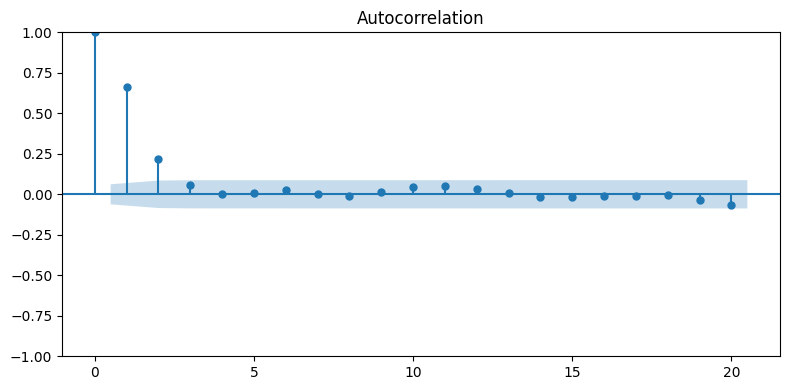

In [6]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()

# plt.savefig('figures/CH06_F05_peixeiro.png', dpi=300)

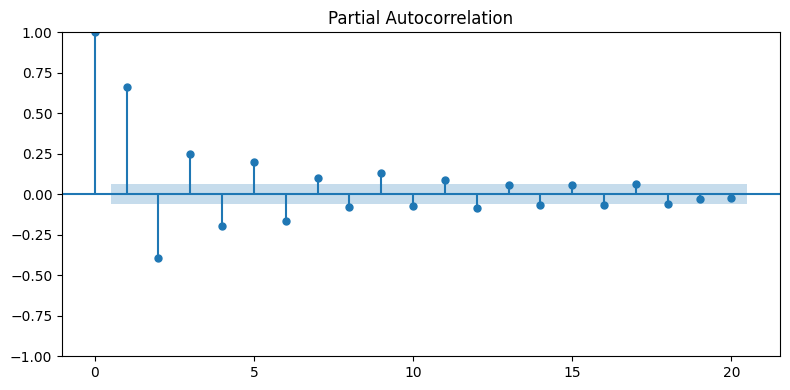

In [7]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()

# plt.savefig('figures/CH06_F06_peixeiro.png', dpi=300)

In [8]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [17]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in order_list:
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.129047
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


## 6.4.4 Performing residuals analysis¶

In [19]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

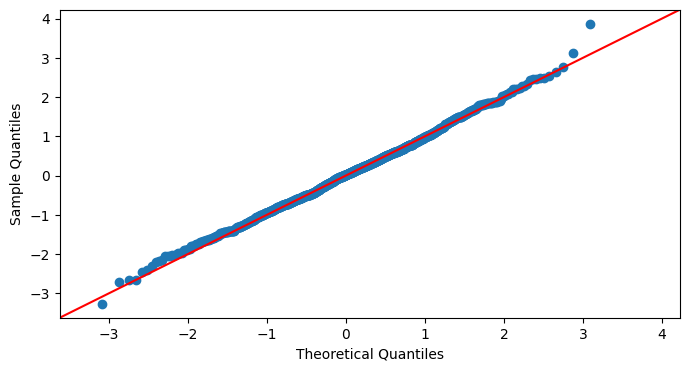

In [22]:
from statsmodels.graphics.gofplots import qqplot

_ = qqplot(residuals, line='45')

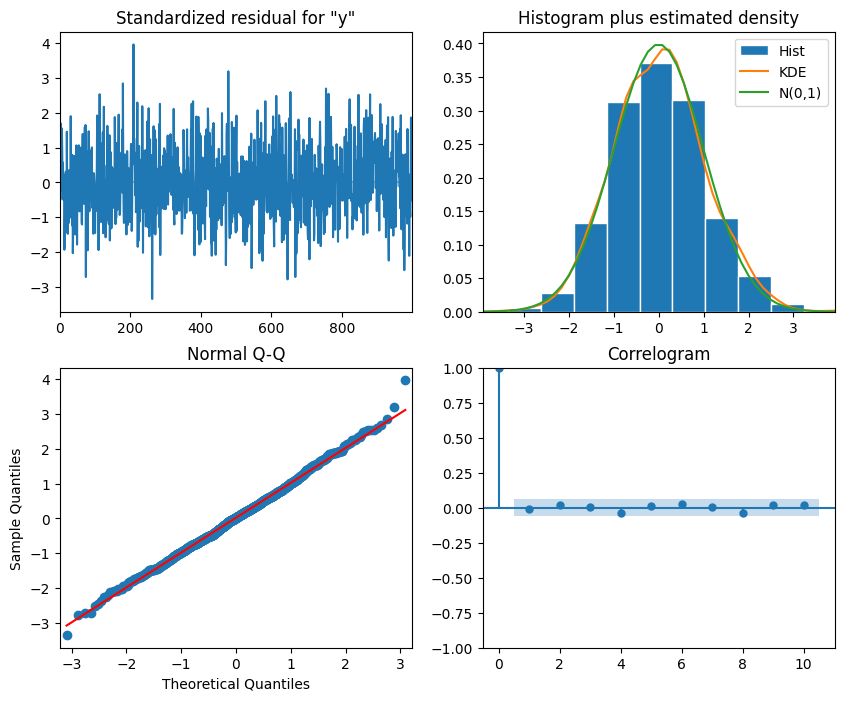

In [23]:
model_fit.plot_diagnostics(figsize=(10, 8));


In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lbvalue)
print(pvalue)

lb_stat
lb_pvalue


In [27]:
pvalue

'lb_pvalue'

## 6.5 Applying the general modeling procedure 

In [29]:
import pandas as pd

df = pd.read_csv('bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


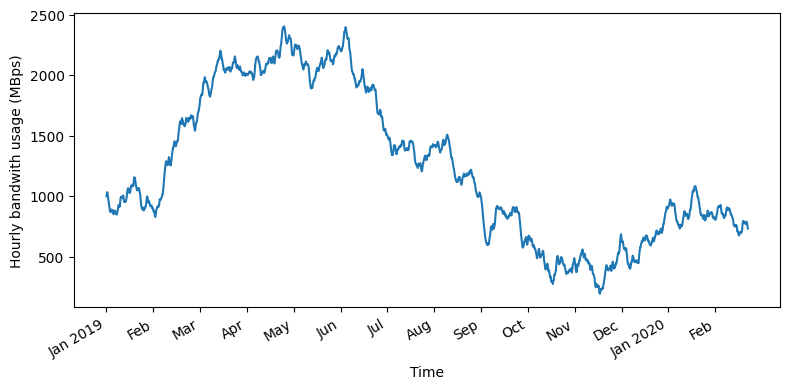

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F02_peixeiro.png', dpi=300)

In [32]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452538
p-value: 0.7972240255014613


In [34]:
bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)
bandwidth_diff

array([ 0.47269411,  1.07661104,  2.65609895, ..., -2.84823217,
       -2.49835551, -1.36959095])

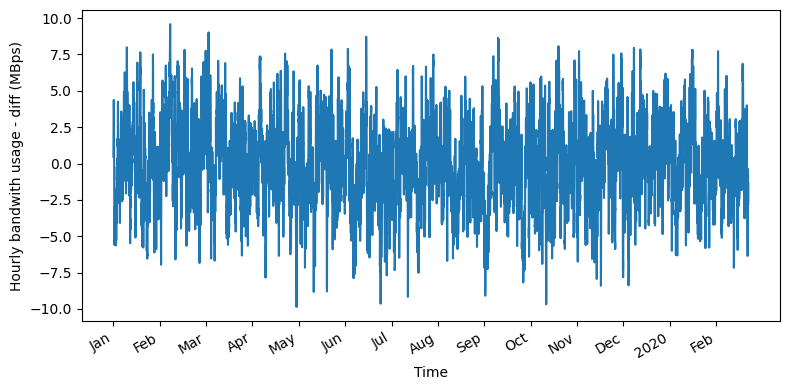

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)